In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 37.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:


import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [ ]:
df = pd.read_csv("BAJAJFINSV.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


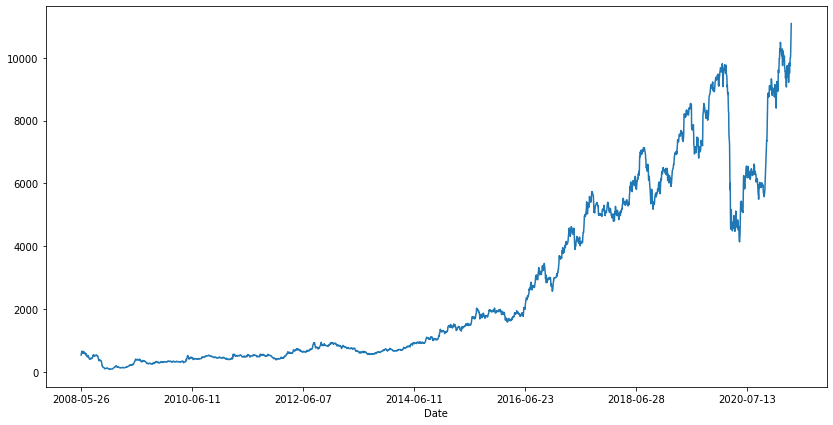

In [ ]:
df.VWAP.plot(figsize=(14, 7))

In [ ]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,9.306704e+13,3.202323e+13,4.039686e+13,5.419116e+13,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,1.726368e+14,3.202323e+13,4.039686e+13,5.419116e+13,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,2.107369e+14,5.388164e+13,5.388164e+13,5.388164e+13,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,2.350756e+14,5.682195e+13,5.682195e+13,5.682195e+13,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,2.508797e+14,2.541759e+13,5.613884e+13,5.613884e+13,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562


In [ ]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-26,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,...,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562,5,22,26,0
2008-05-27,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,...,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562,5,22,27,1
2008-05-28,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,...,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562,5,22,28,2
2008-05-29,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,...,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562,5,22,29,3
2008-05-30,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,...,20805.800781,20746.580078,20480.105469,6680.799805,8337.47168,10924.101562,5,22,30,4


In [ ]:


df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]



In [ ]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29826.104, Time=19.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29811.893, Time=8.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=29683.298, Time=8.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=30130.975, Time=13.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=47844.590, Time=11.43 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29792.166, Time=26.75 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29883.614, Time=20.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=29821.523, Time=13.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29680.586, Time=8.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=29790.419, Time=12.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29881.507, Time=12.87 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=30128.841, Time=12.65 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29819.721, Time=13.40 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 180.748 secon

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


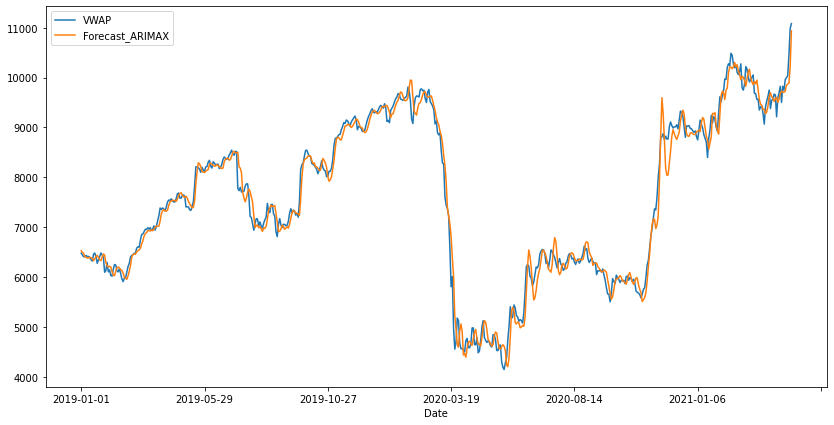

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 224.3171866580387

MAE of Auto ARIMAX: 160.21440434051922


In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


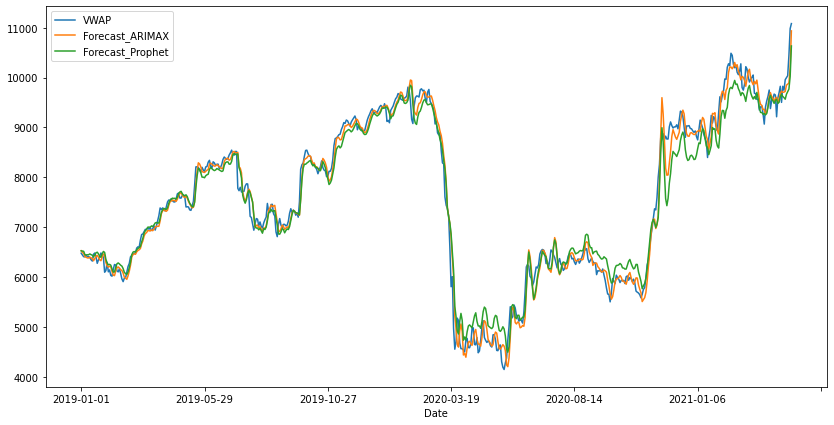

In [ ]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [ ]:


print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))


